In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
df = pd.read_csv('../../data/processed_data/processed_data.csv')
df.head()

,ano,State,Value,mes_5_PRCP,mes_6_PRCP,mes_7_PRCP,mes_8_PRCP,mes_5_TMean,mes_6_TMean,mes_7_TMean,...,mes_7_TMAX,mes_8_TMAX,mes_5_TMIN,mes_6_TMIN,mes_7_TMIN,mes_8_TMIN,mes_5_diff,mes_6_diff,mes_7_diff,mes_8_diff
0,1973,ARKANSAS,35.0,42.308973,45.402410,35.477990,15.372602,193.839225,246.650481,268.067658,...,328.655244,326.769319,125.061019,183.932673,207.498746,187.769055,137.549066,125.435617,121.134969,139.004812
1,1974,ARKANSAS,44.0,44.904795,72.178190,20.984679,47.830850,219.738361,225.039917,274.031891,...,343.424095,314.035861,161.500496,162.957676,204.639687,189.845442,116.451663,124.155148,138.784408,124.165425
2,1975,ARKANSAS,50.0,51.879732,42.705725,27.444048,34.489151,216.171408,244.717019,263.674473,...,327.976356,319.033057,155.817551,183.790625,199.373975,202.361080,120.710481,121.846539,128.583133,116.680717
3,1976,ARKANSAS,56.0,43.245414,50.554939,21.466434,13.742867,177.125868,229.556643,261.141791,...,327.687374,325.192957,111.058260,168.628025,194.599055,173.279941,132.115768,121.857235,133.085472,152.009498
4,1977,ARKANSAS,53.0,16.920457,35.243911,35.796927,26.661465,226.244111,262.637452,277.435751,...,339.202121,328.781318,158.645162,194.591207,215.668843,206.371685,135.186214,136.071042,123.533815,122.375183


Vamos tentar comparar a produtividade dos estados, para procurar entender se há alguma relação entre as posições geográficas.

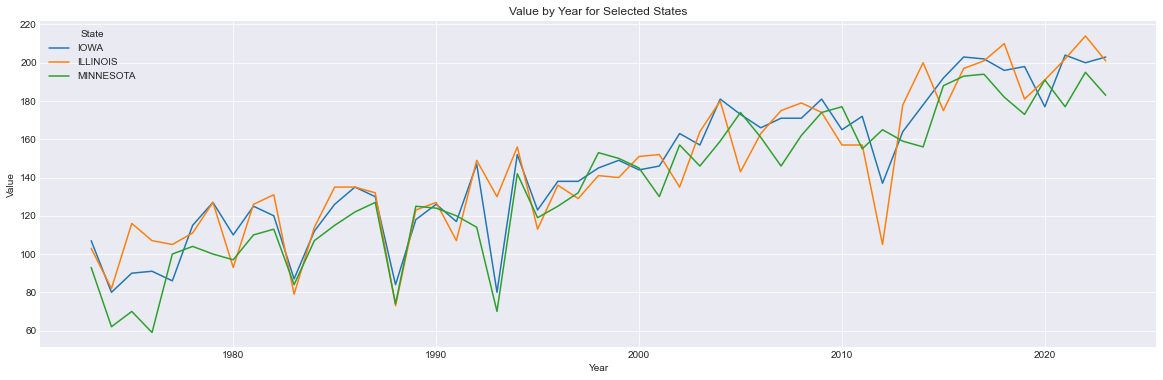

In [27]:
def plot_state_values(df, states):
    """
    Função para plotar os valores ao longo dos anos para um ou mais estados.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo as colunas 'State', 'ano' e 'Value'.
        states (list of str): Lista contendo os nomes dos estados que deseja plotar.

    Retorna:
        None, mas plota um gráfico de linhas dos valores ao longo dos anos para os estados especificados.
    """

    if not isinstance(states, list):
        states = [states]


    df_filtered = df[df['State'].isin(states)]


    plt.figure(figsize=(20, 6))
    for state in df_filtered['State'].unique():
        df_state = df_filtered[df_filtered['State'] == state]

        anos = np.array(df_state['ano'])
        valores = np.array(df_state['Value'])
        plt.plot(anos, valores, label=state)

    plt.title('Value by Year for Selected States')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend(title='State')
    plt.grid(True)
    plt.show()

plot_state_values(df, ['IOWA', 'ILLINOIS', 'MINNESOTA'])

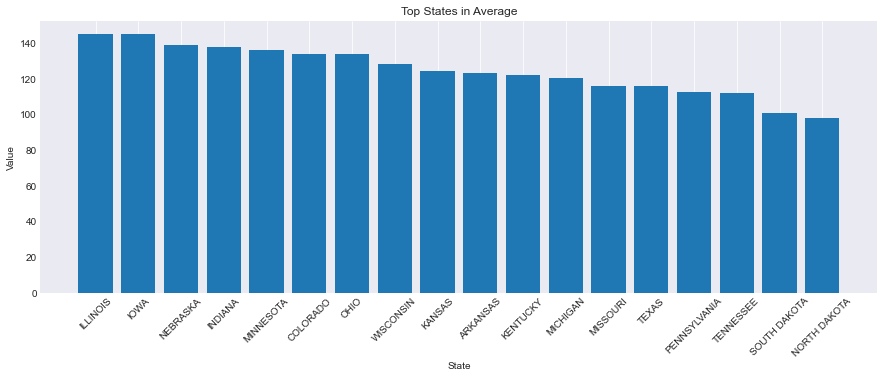

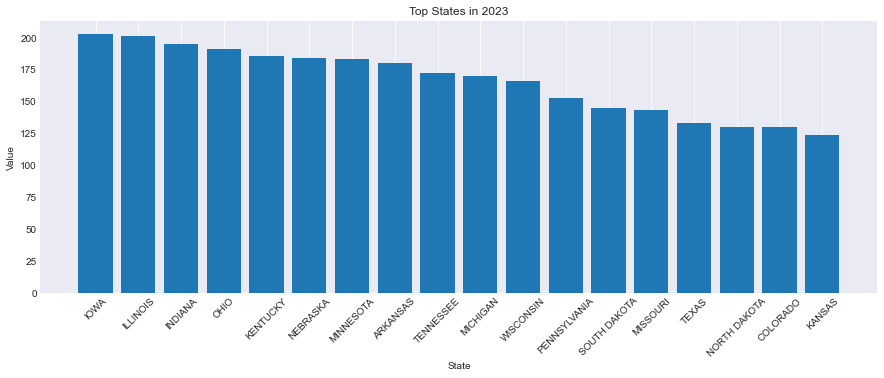

In [28]:
df_mean = df.groupby('State').mean().reset_index()
df_mean = df_mean.sort_values('Value', ascending=False)
df_mean = df_mean[['State', 'Value']]


plt.figure(figsize=(15, 5))
plt.bar(df_mean['State'], df_mean['Value'])
plt.title('Top States in Average')
plt.xlabel('State')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


top_2023 = df[df['ano'] == 2023].sort_values('Value', ascending=False)
top_2023 = top_2023[['State', 'Value']]

plt.figure(figsize=(15, 5))
plt.bar(top_2023['State'], top_2023['Value'])
plt.title('Top States in 2023')
plt.xlabel('State')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

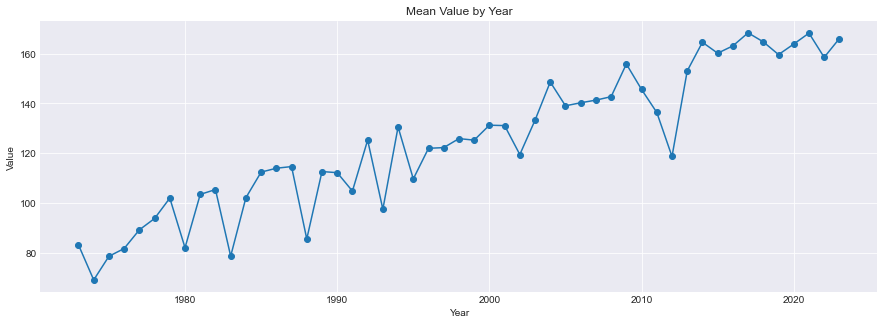

In [34]:
#df_2 is df without column 'State'
df_2 = df.drop(columns='State')


df_mean = df_2.groupby('ano').mean().reset_index()  # Supondo que 'ano' agora é corretamente numérico
anos = np.array(df_mean['ano'])
valores = np.array(df_mean['Value'])

plt.figure(figsize=(15, 5))
plt.plot(anos, valores, marker='o')  # Uso direto de arrays NumPy
plt.title('Mean Value by Year')
plt.xlabel('Year')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Conseguimos notar que os estados que mais produzem milho estão geograficamente perto um aos outros, conferindo na média dos anos e em 2023. então possivelmente a posição geográfica dos estados possui relevância para a produtividade final. Com a função que plota a produtividade ao longo do tempo, conseguimos comparar melhor alguns estados. 

Agora, vamos tentar ver como é o comportamento do clima nesses estados.

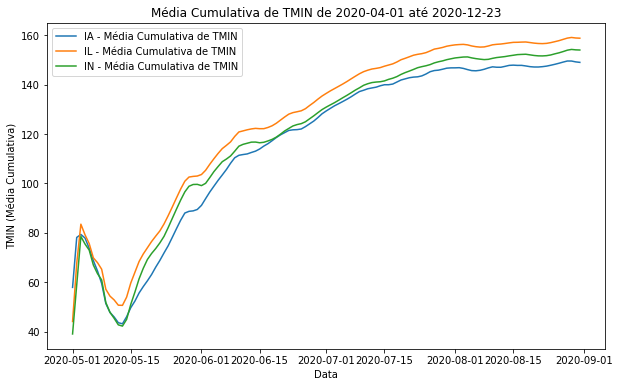

In [5]:
def plot_rolling_average(states, variable, start_date, end_date, date_col='data'):
    plt.figure(figsize=(10, 6))
    
    for state in states:
        csv_path = f'../../data/raw_data_NOAA/by_day_and_state/{state}.csv'
        df = pd.read_csv(csv_path)
        
        df[date_col] = pd.to_datetime(df[date_col])
        
        mask = (df[date_col] >= start_date) & (df[date_col] <= end_date)
        df_filtered = df.loc[mask].copy()
        
        if df_filtered.empty:
            print(f"Nenhum dado encontrado para {state} entre {start_date} e {end_date}. Verifique as datas e tente novamente.")
            continue
        

        df_filtered.sort_values(date_col, inplace=True)
        
        df_filtered[f'{variable}_mean'] = df_filtered[variable].expanding(min_periods=1).mean()
        
        dates_np = np.array(df_filtered[date_col])
        variable_mean_np = np.array(df_filtered[f'{variable}_mean'])
        

        plt.plot(dates_np, variable_mean_np, label=f'{state} - Média Cumulativa de {variable}')

    plt.title(f'Média Cumulativa de {variable} de {start_date} até {end_date}')
    plt.xlabel('Data')
    plt.ylabel(f'{variable} (Média Cumulativa)')
    plt.legend()
    plt.show()


plot_rolling_average(['IA', 'IL', 'IN'], 'TMIN', '2020-04-01', '2020-12-23')


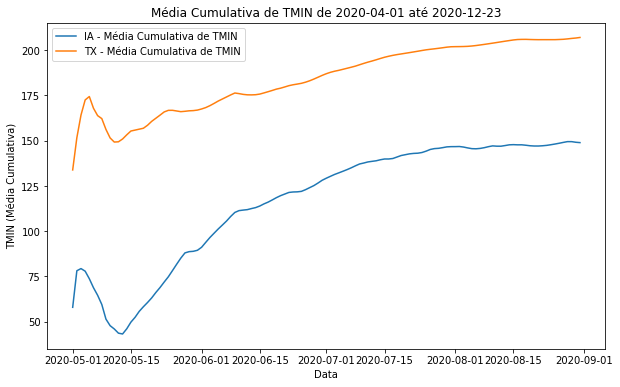

In [6]:
plot_rolling_average(['IA', 'TX'], 'TMIN', '2020-04-01', '2020-12-23')

Comparando o clima, é possível ver como estados geograficamente próximos possuem climas semelhantes, enquanto aqueles que se situam mais longe tem clima diferente. É possível alterar os estados analisados, a variável de interesse e o período pelos parâmetros da função, para melhor entendimento.

Agora, vamos trabalhar especificamente com essas variáveis climáticas para entendermos o comportamento de cada uma delas melhor. Identificar multicolinearidade ou meses mais impactantes será de extrema importância para nosso problema. Entretanto, no nosso problema temos a questão do claro efeito temporal na produção, que será levado em conta na modelagem. Porém, para conseguirmos selecionar quais covariáveis utilizar e ver o efeito de cada uma no yield em si, faz mais sentido anularmos esse efeito temporal para evitarmos viés. Portanto, vamos ver a correlação de cada variável climática com o desvio da tendência do yield, assim poderemos ter uma análise mais objetiva.

In [7]:
def get_deviation(state_df):
    state_df_ = state_df.copy()
    X = sm.add_constant(state_df_['ano'])
    y = state_df_['Value']
    model = sm.OLS(y, X).fit()

    state_df_['Predict'] = model.predict(X)
    state_df_['Deviation'] = state_df_['Value'] / state_df_['Predict'] - 1
    return state_df_

sy = df

states_list = ['IOWA','ILLINOIS','MINNESOTA','NEBRASKA','INDIANA','SOUTH DAKOTA',
               'OHIO', 'WISCONSIN','KANSAS', 'MISSOURI','NORTH DAKOTA','MICHIGAN',
               'KENTUCKY','TEXAS','ARKANSAS','COLORADO','PENNSYLVANIA','TENNESSEE']
states = {}
devs = {}
for state in states_list:
    states[state] = sy[sy['State'] == state]
    devs[state] = get_deviation(states[state])[['ano', 'Deviation']]

devs_df = pd.concat(devs, axis=0)
devs_df.reset_index(inplace=True)
devs_df.rename(columns={'level_0': 'State'}, inplace=True)
devs_df.drop('level_1', axis=1, inplace=True)

sy_devs = pd.merge(sy, devs_df, on=['State', 'ano'])
sy_devs

,ano,State,Value,mes_5_PRCP,mes_6_PRCP,mes_7_PRCP,mes_8_PRCP,mes_5_TMean,mes_6_TMean,mes_7_TMean,...,mes_8_TMAX,mes_5_TMIN,mes_6_TMIN,mes_7_TMIN,mes_8_TMIN,mes_5_diff,mes_6_diff,mes_7_diff,mes_8_diff,Deviation
0,1973,ARKANSAS,35.0,42.308973,45.402410,35.477990,15.372602,193.839225,246.650481,268.067658,...,326.769319,125.061019,183.932673,207.498746,187.769055,137.549066,125.435617,121.134969,139.004812,-0.305967
1,1974,ARKANSAS,44.0,44.904795,72.178190,20.984679,47.830850,219.738361,225.039917,274.031891,...,314.035861,161.500496,162.957676,204.639687,189.845442,116.451663,124.155148,138.784408,124.165425,-0.175135
2,1975,ARKANSAS,50.0,51.879732,42.705725,27.444048,34.489151,216.171408,244.717019,263.674473,...,319.033057,155.817551,183.790625,199.373975,202.361080,120.710481,121.846539,128.583133,116.680717,-0.111179
3,1976,ARKANSAS,56.0,43.245414,50.554939,21.466434,13.742867,177.125868,229.556643,261.141791,...,325.192957,111.058260,168.628025,194.599055,173.279941,132.115768,121.857235,133.085472,152.009498,-0.053519
4,1977,ARKANSAS,53.0,16.920457,35.243911,35.796927,26.661465,226.244111,262.637452,277.435751,...,328.781318,158.645162,194.591207,215.668843,206.371685,135.186214,136.071042,123.533815,122.375183,-0.146245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,2019,COLORADO,123.0,24.203423,17.171788,17.321356,11.642404,71.877893,140.830055,187.480103,...,267.323011,4.756823,61.364089,104.446298,101.545158,133.667399,158.108846,165.625076,165.594273,-0.128804
914,2020,COLORADO,116.0,11.806729,11.999329,13.811263,6.495522,114.937458,162.192910,187.641899,...,282.503454,33.130154,77.082646,104.425247,105.683337,162.957702,169.412343,165.674031,176.533553,-0.180425
915,2021,COLORADO,129.0,29.184520,12.867639,17.848233,12.233049,98.065725,168.106907,191.118848,...,258.075363,23.693595,82.484524,110.649224,92.893447,148.143168,170.911007,160.331349,165.126941,-0.090834
916,2022,COLORADO,121.0,16.709611,12.416524,23.213654,17.474071,99.683699,159.707984,191.282139,...,255.485046,21.923138,79.202660,114.403277,104.264342,155.371273,160.738831,153.617875,151.028081,-0.149324


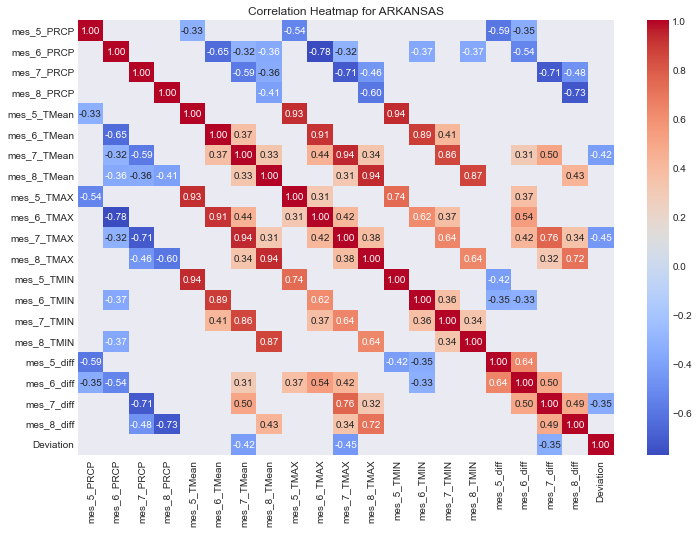

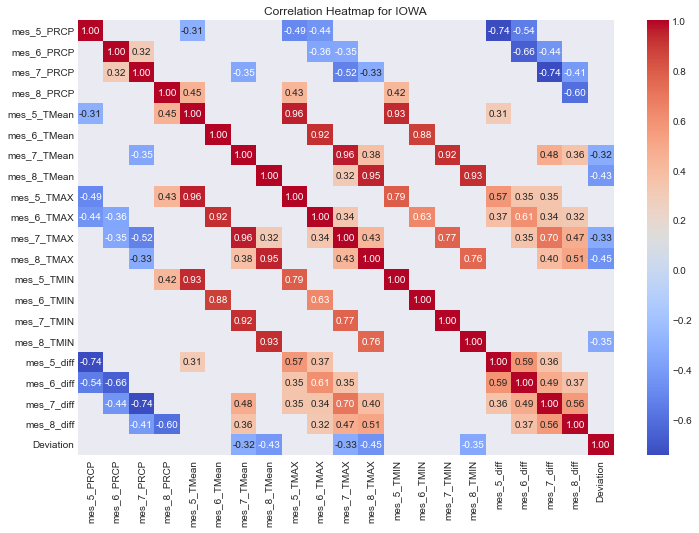

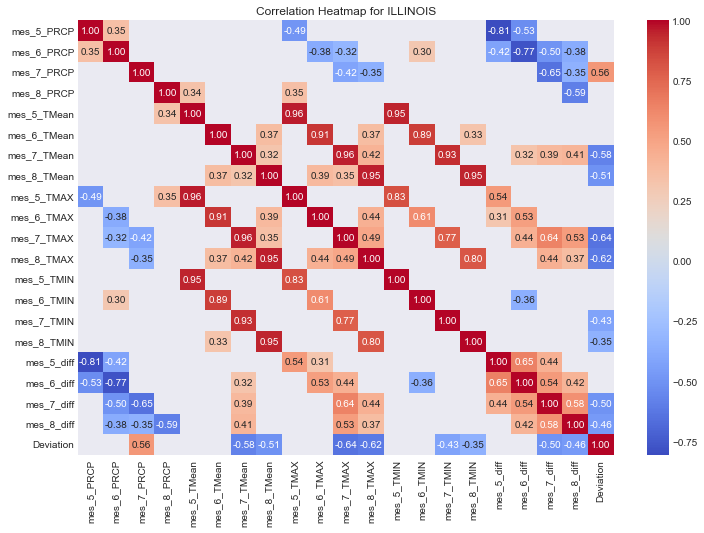

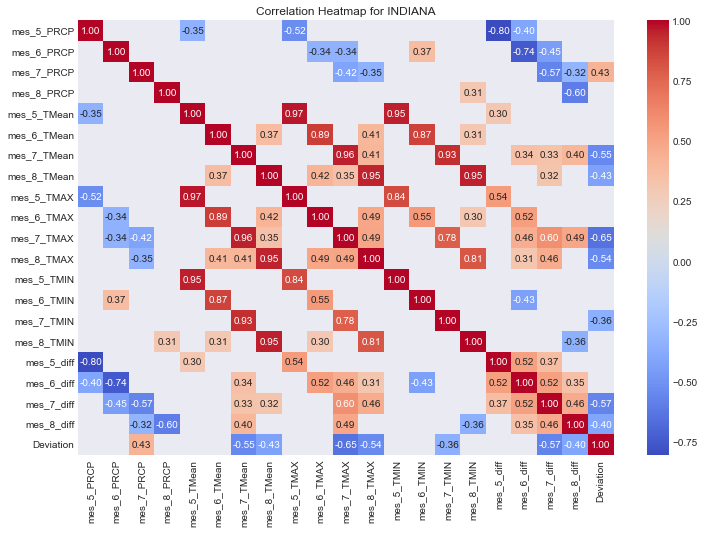

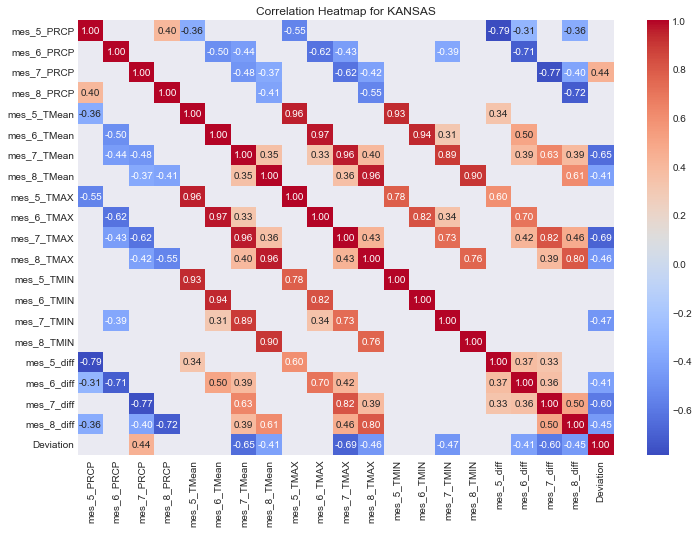

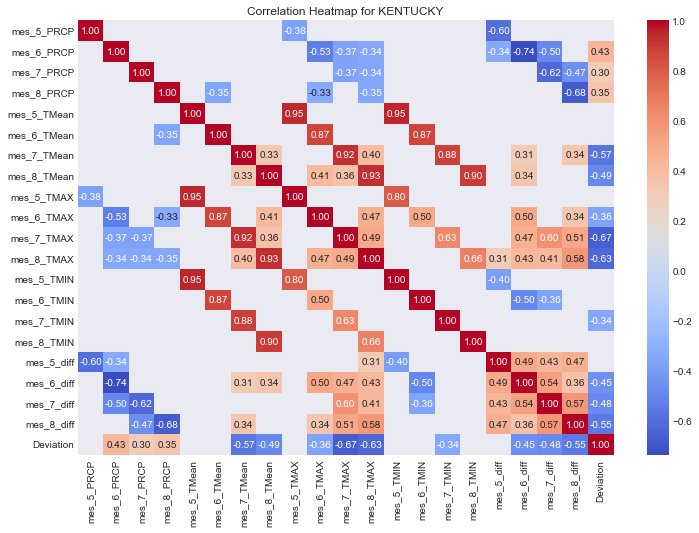

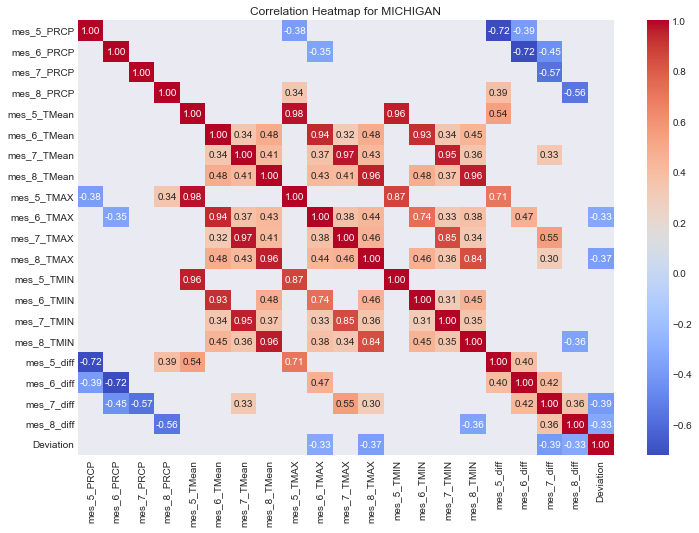

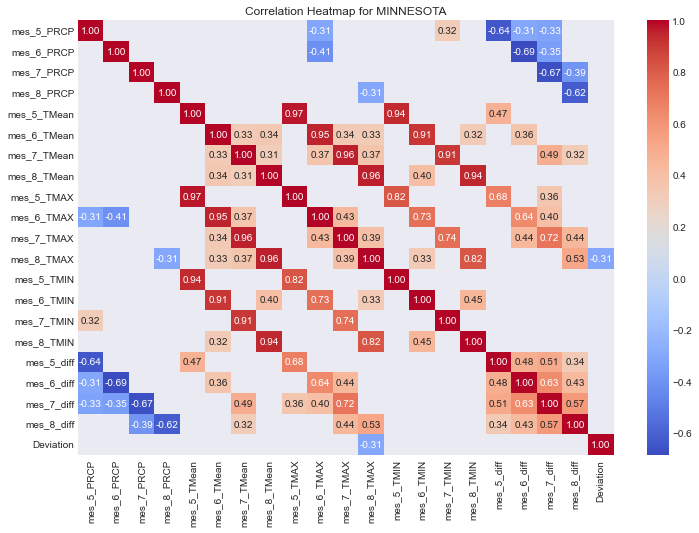

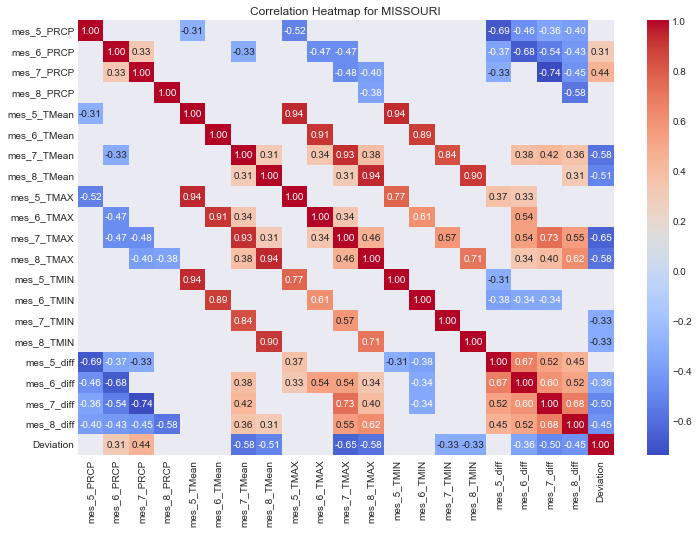

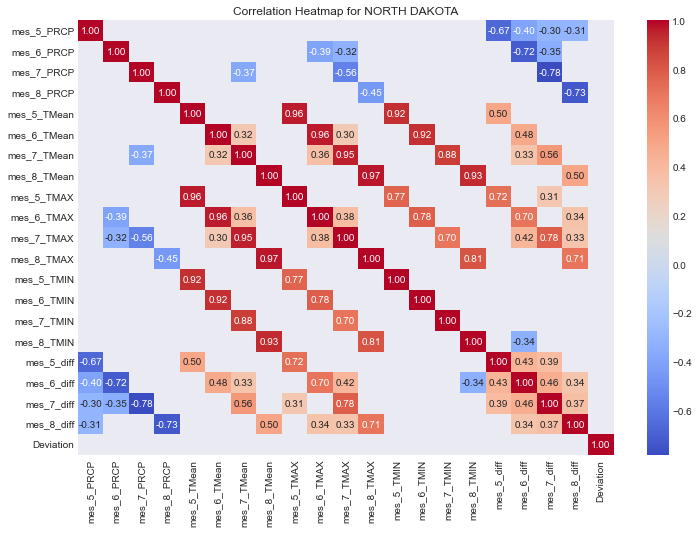

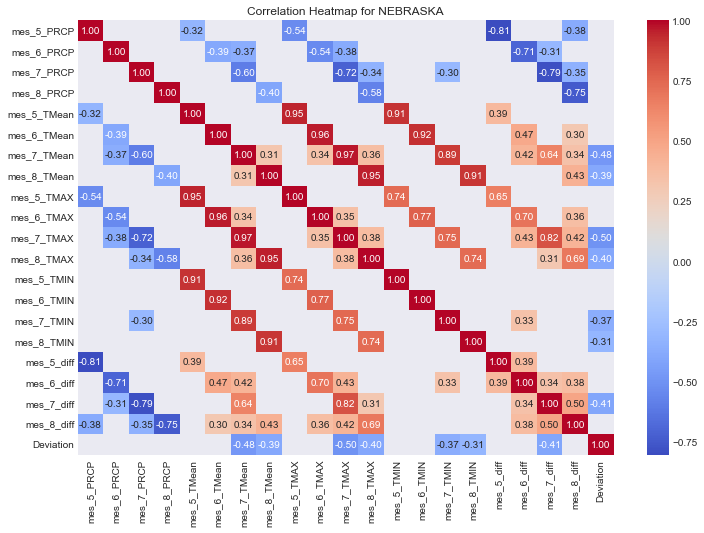

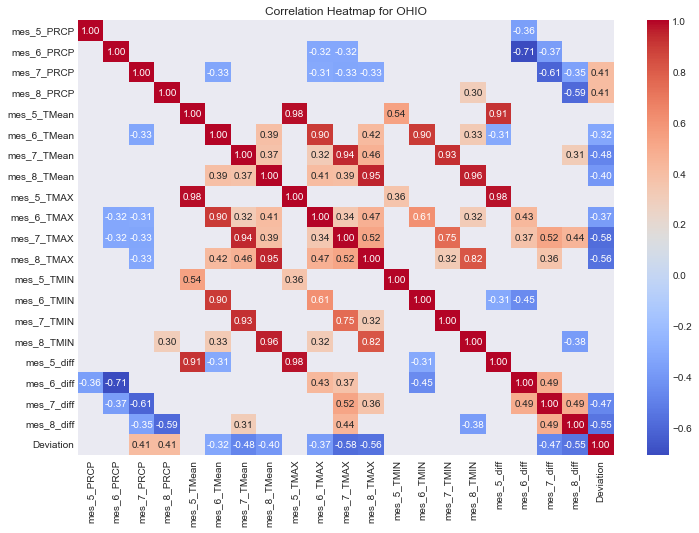

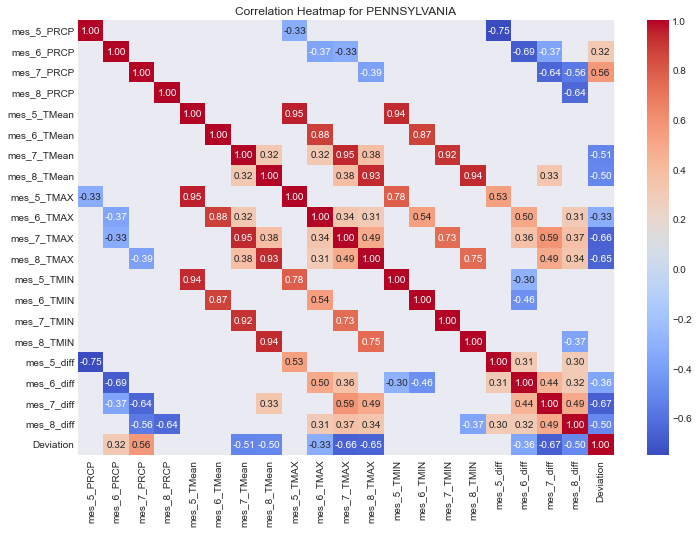

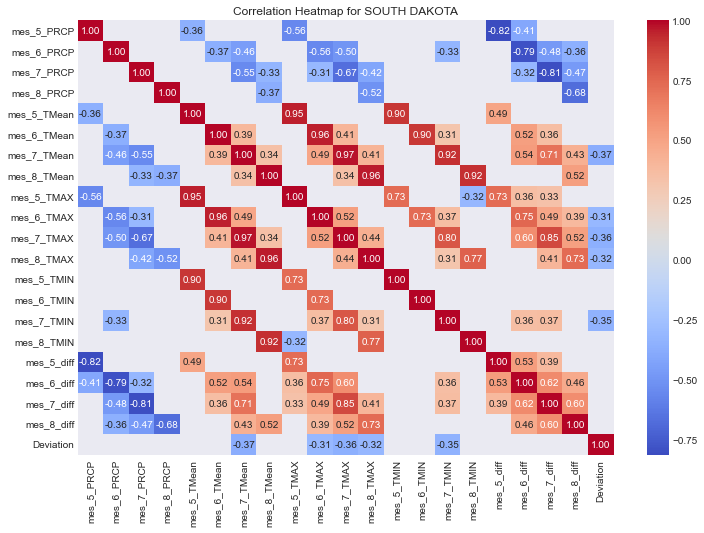

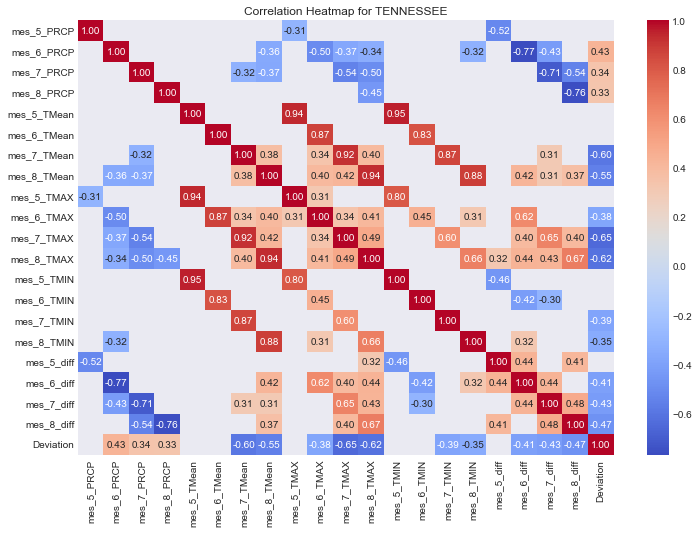

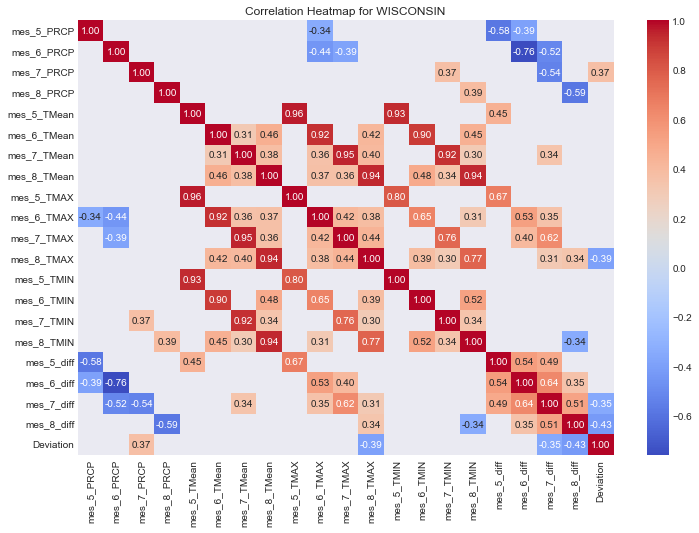

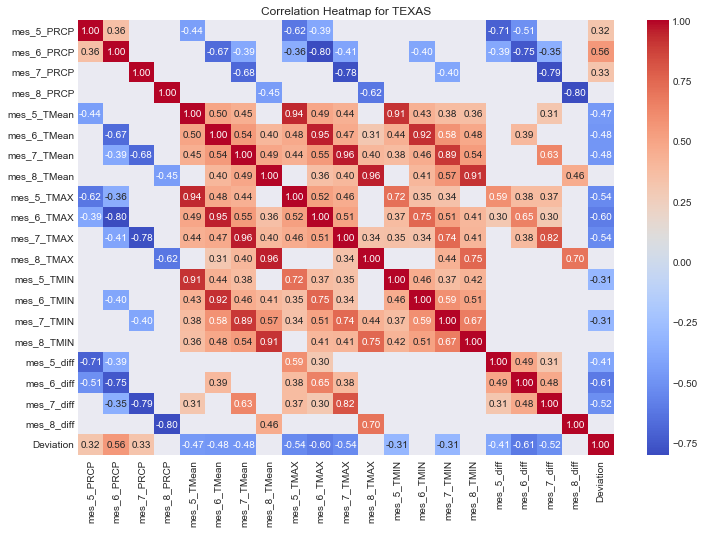

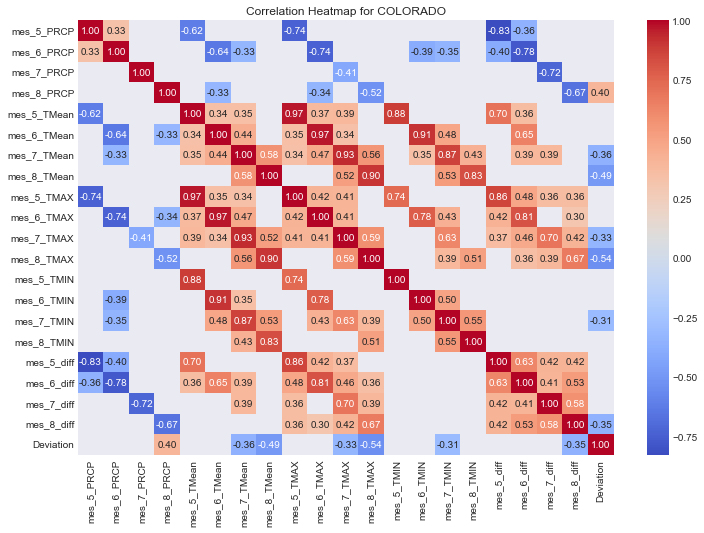

In [8]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

covar_columns = [col for col in sy_devs.columns if 'mes' in col]

unique_states = sy_devs['State'].unique()

for state in unique_states:
    plt.figure()
    state_df = sy_devs[sy_devs['State'] == state][covar_columns + ['Deviation']]
    correlation_matrix = state_df.corr()

    #vou filtrar apenas as correlações acima de 0.3 ou abaixo de -0.3 para facilitar a visualização, mas podemos alterar esse valor
    correlation_matrix = correlation_matrix[(correlation_matrix >= 0.3) | (correlation_matrix <= -0.3)]

    correlation_matrix = correlation_matrix.replace(to_replace=[np.nan], value=np.nan)

    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=correlation_matrix.isnull())
    plt.title(f'Correlation Heatmap for {state}')
    plt.show()

É possível notar que em todos os estados, o mês 5 de cada variável parece ter pouca correlação com a variável resposta. Isso confirma uma hipótese que tinhamos na nossa revisão de literatura, que não coloca o mês de maio como crucial para a produtividade. Portanto, vamos nos concentrar nos meses 6, 7 e 8 para nossa modelagem.

Outra questão é que, apesar de algumas covariáveis terem uma boa correlação com o desvio da tendência do $\textit{yield}$, precisamos nos atentar a multicolinearidade entre elas. Não basta simplesmente selecionar as covariáveis com maior correlação pois poderiamos ter um efeito negativo a nossa modelagem, adicionando complexidade e multicolinearidade.

Outra informação importante é que a precipitação, de modo geral, parece ter um efeito mais considerável nos meses de junho e julho, mas principalmente em julho. Alguns estados que ficam mais ao norte do país possuem esse efeito mais acentuado nos meses 7 e 8, possivelmente porque, pela questão geográfica e diferença de temperaturas, começam o plantio mais tardio (confirmei essa informação com dados do USDA, que divulga semanalmente o progresso de plantio https://usda.library.cornell.edu/concern/publications/8336h188j)


Vamos analisar as covariáveis do mês de julho em Illinois, que parece ter sido o mês crucial nesse estado:

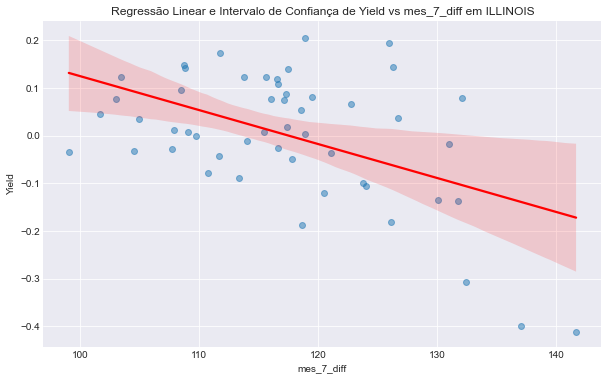

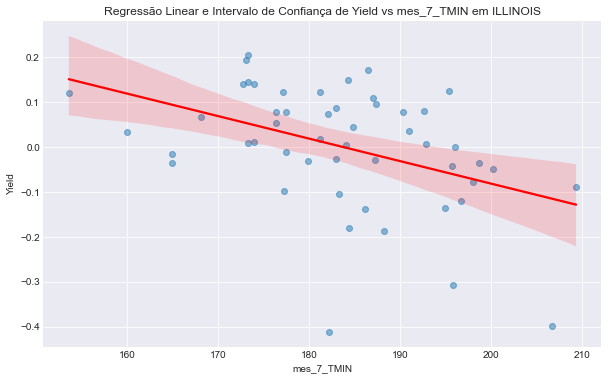

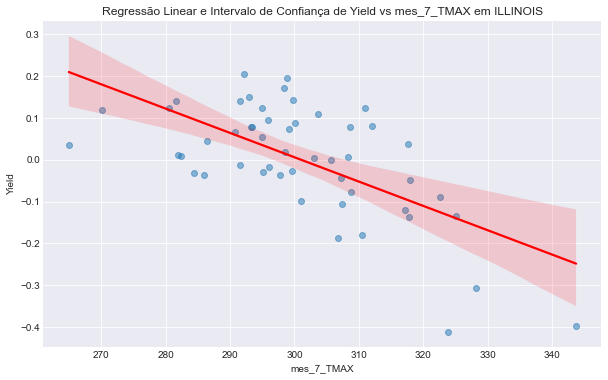

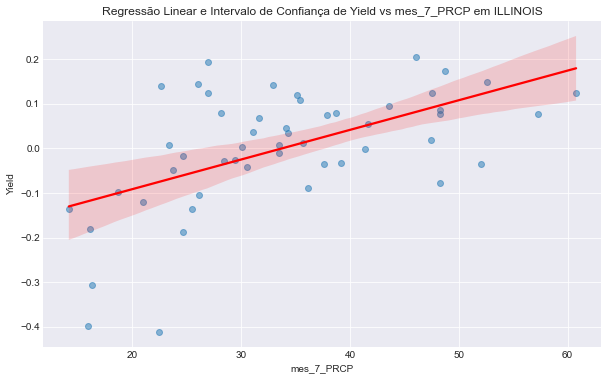

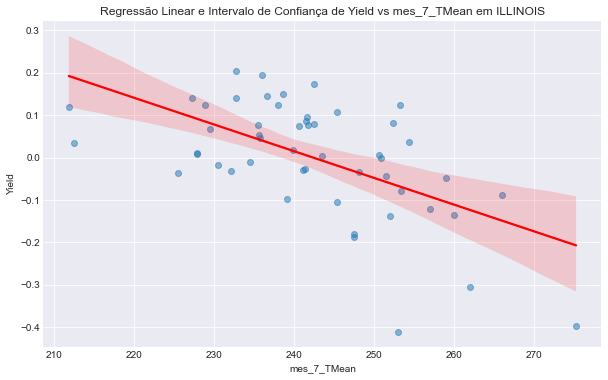

In [9]:
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Lista de estados de interesse
selected_states = ['ILLINOIS']

# Colunas de variáveis importantes
important_vars = ['mes_7_diff', 'mes_7_TMIN', 'mes_7_TMAX', 'mes_7_PRCP', 'mes_7_TMean']

# Filtrar o DataFrame para incluir apenas os estados selecionados
filtered_df = sy_devs[sy_devs['State'].isin(selected_states)]

# Plotando regressão linear com intervalo de confiança para cada variável e para cada estado
for state in selected_states:
    state_df = filtered_df[filtered_df['State'] == state]
    for var in important_vars:
        plt.figure(figsize=(10, 6))
        sns.regplot(x=var, y='Deviation', data=state_df, ci=95, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
        plt.title(f'Regressão Linear e Intervalo de Confiança de Yield vs {var} em {state}')
        plt.xlabel(var)
        plt.ylabel('Yield')
        plt.show()